In [1]:
!pip install tensorflow keras split-folders opencv-python

In [2]:
import tensorflow as tf
# libraries for comprehensive neural network buidling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
# library for data augmentation and pre processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
# libraries for organizing data and access
import splitfolders
import cv2
# library to ensure that foramt matches the one expected by the model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

In [3]:
# location directories for input and output
input_folder="/Users/atibp/OneDrive/Desktop/deep-learn-neural-network/agriculture/agricultural-crops"
output_folder="/Users/atibp/OneDrive/Desktop/deep-learn-neural-network/agriculture/agro-images"

# ratio for train, test and validation
split_ratio=[0.8,0.1,0.1]

splitfolders.ratio(
    input_folder,
    output=output_folder,
    # ensures reproducable split
    seed=500,
    ratio=split_ratio,
    group_prefix=None
)

Copying files: 829 files [00:02, 382.06 files/s]


In [4]:
# define image parameters
img_size=(224,224)
batch_size=32

# data augmentation for training data
train_datagen=ImageDataGenerator(
    # input processing method of resnet50
    # scales pixel value to the format expected by pre-trained resnet model
    preprocessing_function=preprocess_input,
    # randomnly rotate image by 20 degree
    rotation_range=20,
    # randomly shift image 20% of width towards left and right
    width_shift_range=0.2,
    # randomly shift image 20% of height towards up and down
    height_shift_range=0.2,
    # random shear transforamtion 
    shear_range=0.2,
    # random zoom by upto 20%
    zoom_range=0.2,
    # randomly flip image horizontally
    horizontal_flip=True,
    # when image randomly shifted or rotated, fill the pixel with nearest values
    fill_mode='nearest'
)

In [5]:
# data augmentation for test data
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
# data augmentation for validation data
valid_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
import os

In [7]:
# directories for images
train_dir=os.path.join(output_folder,'train')
test_dir=os.path.join(output_folder,'test')
valid_dir=os.path.join(output_folder,'val')

# create generators that read images from the directories to applt the specific augmentations in batches
# generate batches of tensor images from specific directory
train_data=train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    # enures that the labels are one hot encoded
    class_mode='categorical'
)

test_data=test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data=valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 652 images belonging to 30 classes.
Found 106 images belonging to 30 classes.
Found 72 images belonging to 30 classes.


In [8]:
import random

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-112.68..151.061].


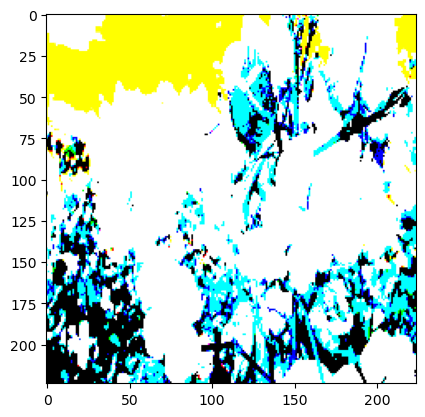

In [9]:
# image and label batch
images,labels=next(valid_data)

# select a random image to display
idx=random.randint(0,images.shape[0]-1)
plt.imshow(images[idx])
plt.show()

In [10]:
# pre-trained model named 'ResNet50'
# ResNet50 is specific architecture of a CNN trained on 'imagenet' dataset
from keras.applications.resnet import ResNet50

# weight are pre-trained on the imagenet
# 'include-yop=False' allows to add custom classification layer
# define shape of the image; size is 224x224 with 3 color channels (RGB)
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(img_size[0],img_size[1],3))

# enures that weight of model don't get updated during training
# this preserves pre-trained weights and only train newly added classification layers
# features learnt from dataset can be used without altering them
base_model.trainable=False

In [11]:
# building model
model=models.Sequential([
    base_model,
    # replace fully conencted layers to reduce overfitting
    layers.GlobalAveragePooling2D(),
    # fully connected dense layer with 128 neurons
    # relu ensures that negative values are replaced with 0
    layers.Dense(128,activation='relu'),
    # randomly switch off 50% inputs during training to prevent overfitting
    layers.Dropout(0.5),
    # fully connected dense layer with 30 neurons
    # softmax ensures that output is converted into probability value between 0 and 1 
    layers.Dense(30,activation='softmax')
])

In [12]:
# optimizer ensures weights are updated to minimize loss
# loss ensures that predicted and actual difference as low as possible
# accuracy is how many correct outcomes have been identified 
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
model.fit(train_data,epochs=20,validation_data=valid_data)

C:\Users\atibp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 175s 7s/step - accuracy: 0.0522 - loss: 3.8606 - val_accuracy: 0.3611 - val_loss: 2.8480
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step - accuracy: 0.1334 - loss: 2.9818 - val_accuracy: 0.4722 - val_loss: 2.3006
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.3104 - loss: 2.4938 - val_accuracy: 0.5556 - val_loss: 1.8640
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.3827 - loss: 2.2008 - val_accuracy: 0.6250 - val_loss: 1.5530
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.4549 - loss: 1.9677 - val_accuracy: 0.6806 - val_loss: 1.3155
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.5138 - loss: 1.6706 - val_accuracy: 0.6806 - val_loss: 1.2538
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.5855 - loss: 1.4799 - val_accuracy: 0.6389 - val_loss: 1.0724
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.5943 - loss: 1.4380 - val_accuracy: 0.7222 - v

In [14]:
# model evaluation on test data
test_loss,test_accuracy=model.evaluate(test_data)
print(f'Test accuracy: {test_accuracy*100:.3f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8390 - loss: 0.6599
Test accuracy: 83.962%


In [15]:
class_names={0:'Cherry',1:'Coffee-plant',2:'Cucumber',3:'Fox_nut(Makhana)',4:'Lemon',5:'Olive-tree',
             6:'Pearl_millet(bajra)',7:'Tobacco-plant',8:'almond',9:'banana',10:'cardamom',11:'chilli',12:'clove',
             13:'coconut',14:'cotton',15:'gram',16:'jowar',17:'jute',18:'maize',19:'mustard-oil',20:'papaya',
             21:'pineapple',22:'rice',23:'soyabean',24:'sugarcane',25:'sunflower',26:'tea',
             27:'tomato',28:'vigna-radiati(Mung)',29:'wheat'}

In [16]:
def predict_img(image,model):
    # read image from specific path into a numpy array
    test_img=cv2.imread(image)
    # resize to dimension 224x224
    test_img=cv2.resize(test_img,(224,224))
    test_img=preprocess_input(test_img)
    # extra dimension to image array 
    test_img=np.expand_dims(test_img,axis=0)
    # using trained model to make prediction
    result=model.predict(test_img)
    # return index of the maximum value corresponding to class wth highst probability
    r=np.argmax(result)
    # map prediction to corresponding class
    print(class_names[r])

In [26]:
predict_img("/Users/atibp/OneDrive/Desktop/deep-learn-neural-network/agriculture/agro-images/test/tomato/image (17).jpg",model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
tomato


In [28]:
predict_img("/Users/atibp/OneDrive/Desktop/deep-learn-neural-network/agriculture/agro-images/test/Lemon/image30.jpg",model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
papaya


In [30]:
predict_img("/Users/atibp/OneDrive/Desktop/deep-learn-neural-network/agriculture/agro-images/test/banana/image (10).jpg",model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
banana
